# Getaround - Delay analysis EDA

In [1]:
# Import useful libraries
import pandas as pd 
import numpy as np
import math

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.kaleido.scope.plotlyjs = r'C:\Users\Public\plotly\package_data\plotly.min.js'
pio.renderers.default = "png" # Comment / delete this line for interactive graphs

import warnings
warnings.filterwarnings("ignore")

## 1. Load dataset and display basic informations

In [2]:
# Read dataset
data = pd.read_excel("../00_Data/get_around_delay_analysis.xlsx", sheet_name = "rentals_data")
doc = pd.read_excel("../00_Data/get_around_delay_analysis.xlsx", sheet_name = "Documentation")
data.head() 

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


In [3]:
with pd.option_context('display.max_colwidth', None):
  display(doc)

,field name,Comment
0,rental_id,Unique identifier of the rental
1,car_id,Unique identifier of the car
2,checkin_type,"Flow used for both checkin and checkout. (ie. access and return the car)\nmobile = rental agreement signed on the owner's smartphone\nconnect = car equiped with the Connect technology , opened by the driver with his smartphone.\nNote: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case"
3,state,canceled means that the rental did not happen (was canceled by the driver or the owner).
4,delay_at_checkout_in_minutes,Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
5,previous_ended_rental_id,id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)
6,time_delta_with_previous_rental_in_minutes,"Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rental_id                                   21310 non-null  int64  
 1   car_id                                      21310 non-null  int64  
 2   checkin_type                                21310 non-null  object 
 3   state                                       21310 non-null  object 
 4   delay_at_checkout_in_minutes                16346 non-null  float64
 5   previous_ended_rental_id                    1841 non-null   float64
 6   time_delta_with_previous_rental_in_minutes  1841 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


In [5]:
data.describe(include = "all")

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
count,21310.000000,21310.000000,21310,21310,16346.000000,1841.000000,1841.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN
top,NaN,NaN,mobile,ended,NaN,NaN,NaN
freq,NaN,NaN,17003,18045,NaN,NaN,NaN
mean,549712.880338,350030.603426,NaN,NaN,59.701517,550127.411733,279.288430
std,13863.446964,58206.249765,NaN,NaN,1002.561635,13184.023111,254.594486
min,504806.000000,159250.000000,NaN,NaN,-22433.000000,505628.000000,0.000000
25%,540613.250000,317639.000000,NaN,NaN,-36.000000,540896.000000,60.000000
50%,550350.000000,368717.000000,NaN,NaN,9.000000,550567.000000,180.000000
75%,560468.500000,394928.000000,NaN,NaN,67.000000,560823.000000,540.000000


In [6]:
data.isna().sum()

rental_id                                         0
car_id                                            0
checkin_type                                      0
state                                             0
delay_at_checkout_in_minutes                   4964
previous_ended_rental_id                      19469
time_delta_with_previous_rental_in_minutes    19469
dtype: int64

The data provided to us here identify the rentals of cars made as well as their possible delay in return and if these were rented before.  
Although our dataset contains a total of 21 310 rentals, only 1 841 (~ 8.6%) have a previous rental.

## 2. Visualize data

### 2.1 Checkout analysis

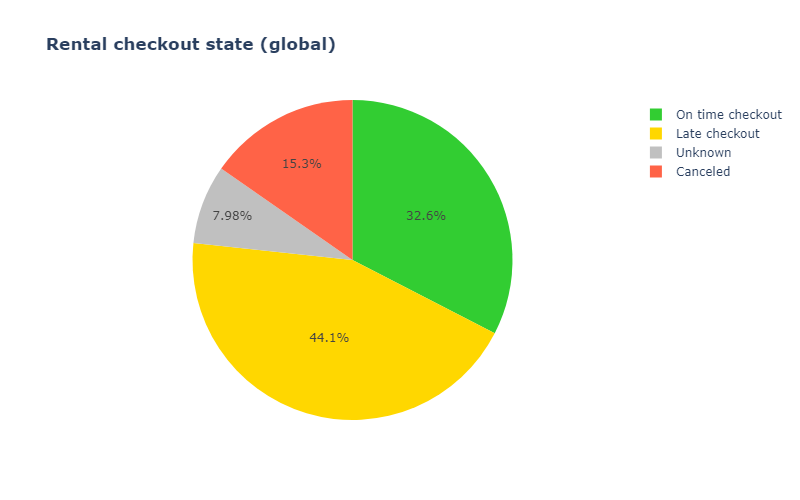

In [7]:
# Piechart of rental state (on time, late, canceled, unknown)

def get_checkout_state(row):
    state = "Unknown"
    if row["state"] == "ended":
        if row["delay_at_checkout_in_minutes"] <= 0:
            state = "On time checkout"
        elif row["delay_at_checkout_in_minutes"] >= 0:
            state = "Late checkout"
    elif row["state"] == "canceled":
        state = "Canceled"
    return state
    
data["precise_state"] = data.apply(get_checkout_state, axis = 1)

checkout_pie = px.pie(data, names = "precise_state", color = "precise_state",
                      color_discrete_map = {
                            "On time checkout": "limegreen",
                            "Late checkout": "gold",
                            "Canceled": "tomato",
                            "Unknown": "silver"},
                      category_orders = {"precise_state": ["On time checkout", "Late checkout", "Unknown", "Canceled"]},
                      title = "<b> Rental checkout state (global) <b>",
                      height = 500, width = 800
                      )
checkout_pie.show()

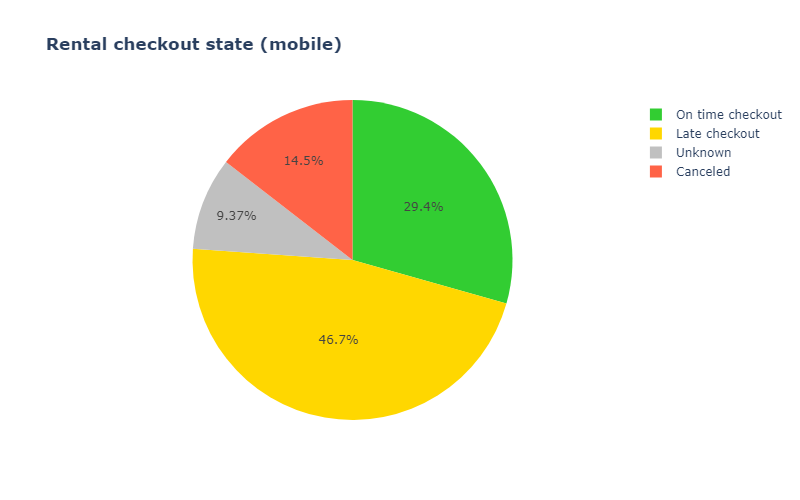

In [8]:
checkout_mobile_pie = px.pie(data[data["checkin_type"] == "mobile"], names = "precise_state", color = "precise_state",
                      color_discrete_map = {
                            "On time checkout": "limegreen",
                            "Late checkout": "gold",
                            "Canceled": "tomato",
                            "Unknown": "silver"},
                      category_orders = {"precise_state": ["On time checkout", "Late checkout", "Unknown", "Canceled"]},
                      title = "<b> Rental checkout state (mobile) <b>",
                      height = 500, width = 800
                      )
checkout_mobile_pie.show()

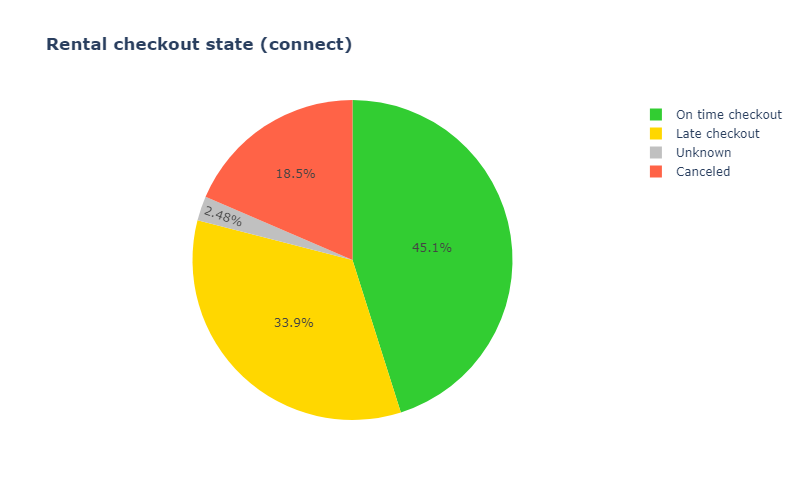

In [9]:
checkout_connect_pie = px.pie(data[data["checkin_type"] == "connect"], names = "precise_state", color = "precise_state",
                      color_discrete_map = {
                            "On time checkout": "limegreen",
                            "Late checkout": "gold",
                            "Canceled": "tomato",
                            "Unknown": "silver"},
                      category_orders = {"precise_state": ["On time checkout", "Late checkout", "Unknown", "Canceled"]},
                      title = "<b> Rental checkout state (connect) <b>",
                      height = 500, width = 800
                      )
checkout_connect_pie.show()

According to these graphic representations, we note that only 32.6% of the rentals are rendered on time or ahead. A large part (44.1%) being late for checkout. Finally, more than 15% of rentals are actually canceled.  
We also note that depending on the reservation means (Connect or mobile) the rate of delay in checkout is not the same: it is higher (46.7%) in the case of "mobile" reservations.

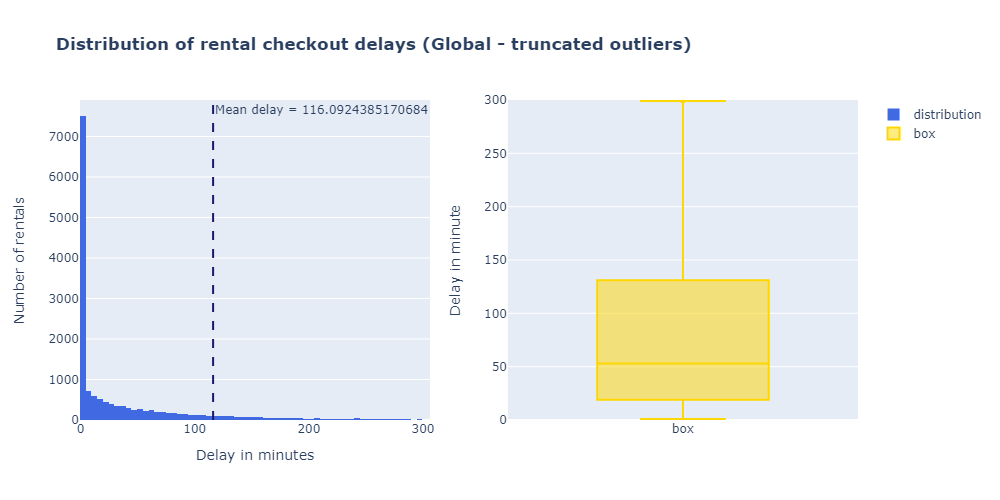

23.55% of rentals have a checkout delay of less then 1h.
The average delay in checkout is 116 minutes.


In [10]:
# Distribution of late checkouts (count vs time) with box (boite à moustache)

data["delays"] = data["delay_at_checkout_in_minutes"].apply(lambda x: 0 if x < 0 else x)

def detect_outliers(dataframe, feature_name):
    q1 = dataframe[feature_name].quantile(0.25)
    q3 = dataframe[feature_name].quantile(0.75)
    interquartile_range = q3 - q1
    upper_fence = math.ceil(q3 + 1.5 * interquartile_range)
    nb_rows = len(dataframe)
    mask = (dataframe[feature_name] <= upper_fence) | (dataframe[feature_name].isna())
    nb_outliers = nb_rows - len(dataframe[mask])
    percent_outliers = round(nb_outliers / nb_rows * 100)
    output = {
        'upper_fence': upper_fence,
        'percent_outliers': percent_outliers
    }
    return output

late_checkouts_upper_fence = detect_outliers(data[data["precise_state"] == "Late checkout"], 'delay_at_checkout_in_minutes')['upper_fence']

state_distribution = make_subplots(rows = 1, cols = 2)

state_distribution.add_trace(go.Histogram(x = data[data["delays"] < late_checkouts_upper_fence]["delays"], name = "distribution", marker_color = "royalblue"), row = 1, col = 1)
state_distribution.add_vline(x = data['delays'].mean(), line_color = "midnightblue", line_dash = "dash", annotation_text = f"Mean delay = {data['delays'].mean()}")
state_distribution.add_trace(go.Box(y = data[data["precise_state"] == "Late checkout"]["delays"], name = "box", marker_color = "gold"), row = 1, col = 2)

state_distribution.update_xaxes(title_text = "Delay in minutes", row = 1, col = 1)
state_distribution.update_yaxes(title_text = "Number of rentals", row = 1, col = 1)
state_distribution.update_yaxes(title_text = "Delay in minute", row = 1, col = 2, range = [0, late_checkouts_upper_fence+1])
state_distribution.update_layout(width = 1000, title_text = "<b> Distribution of rental checkout delays (Global - truncated outliers) <b>")

state_distribution.show()

print(f"{round(len(data[(data['delays'] > 0) & (data['delays'] <= 60)]) / len(data) * 100, 2)}% of rentals have a checkout delay of less then 1h.")
print(f"The average delay in checkout is {round(data['delays'].mean())} minutes.")


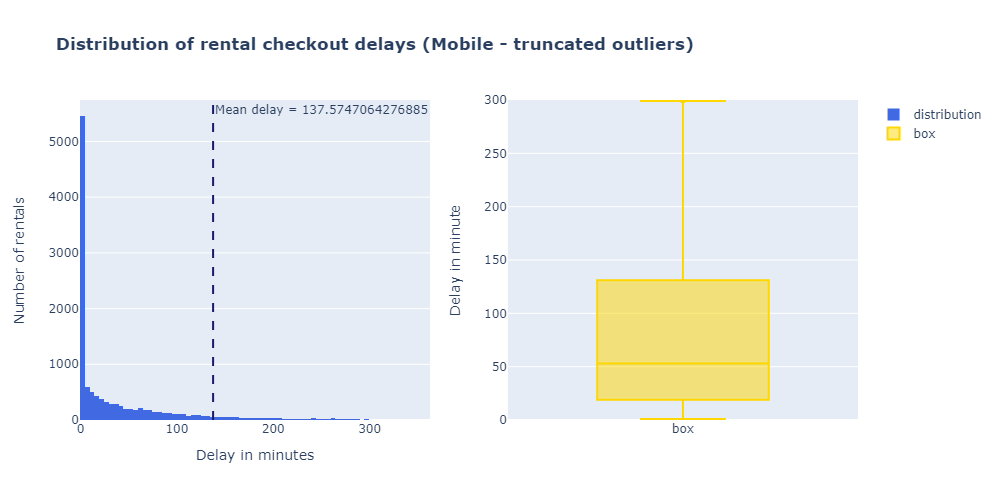

24.18% of mobile rentals have a checkout delay of less then 1h.
The average delay for mobile checkout is 138 minutes.


In [11]:
state_distribution_mobile = make_subplots(rows = 1, cols = 2)

state_distribution_mobile.add_trace(go.Histogram(x = data[(data["checkin_type"] == "mobile") & (data["delays"] < late_checkouts_upper_fence)]["delays"], name = "distribution", marker_color = "royalblue"), row = 1, col = 1)
state_distribution_mobile.add_vline(x = data[data['checkin_type'] == 'mobile']['delays'].mean(), line_color = "midnightblue", line_dash = "dash", annotation_text = f"Mean delay = {data[data['checkin_type'] == 'mobile']['delays'].mean()}")
state_distribution_mobile.add_trace(go.Box(y = data[data["precise_state"] == "Late checkout"]["delays"], name = "box", marker_color = "gold"), row = 1, col = 2)

state_distribution_mobile.update_xaxes(title_text = "Delay in minutes", row = 1, col = 1)
state_distribution_mobile.update_yaxes(title_text = "Number of rentals", row = 1, col = 1)
state_distribution_mobile.update_yaxes(title_text = "Delay in minute", row = 1, col = 2, range = [0, late_checkouts_upper_fence+1])
state_distribution_mobile.update_layout(width = 1000, title_text = "<b> Distribution of rental checkout delays (Mobile - truncated outliers) <b>")

state_distribution_mobile.show()

print(f"{round(len(data[(data['checkin_type'] == 'mobile') & (data['delays'] > 0) & (data['delays'] <= 60)]) / len(data[data['checkin_type'] == 'mobile']) * 100, 2)}% of mobile rentals have a checkout delay of less then 1h.")
print(f"The average delay for mobile checkout is {round(data[data['checkin_type'] == 'mobile']['delays'].mean())} minutes.")

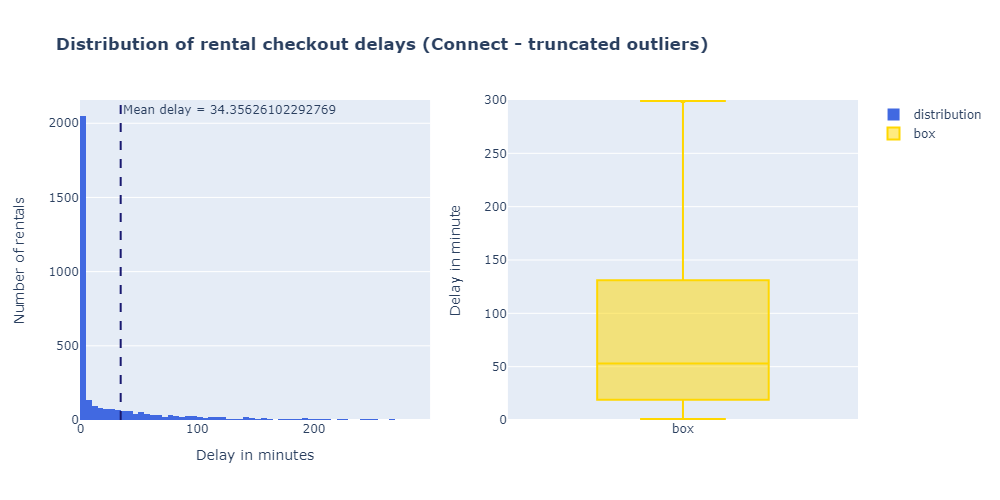

21.04% of connect rentals have a checkout delay of less then 1h.
The average delay for connect checkout is 34 minutes.


In [12]:
state_distribution_connect = make_subplots(rows = 1, cols = 2)

state_distribution_connect.add_trace(go.Histogram(x = data[data["checkin_type"] == "connect"][data["delays"] < late_checkouts_upper_fence]["delays"], name = "distribution", marker_color = "royalblue"), row = 1, col = 1)
state_distribution_connect.add_vline(x = data[data['checkin_type'] == 'connect']['delays'].mean(), line_color = "midnightblue", line_dash = "dash", annotation_text = f"Mean delay = {data[data['checkin_type'] == 'connect']['delays'].mean()}")
state_distribution_connect.add_trace(go.Box(y = data[data["precise_state"] == "Late checkout"]["delays"], name = "box", marker_color = "gold"), row = 1, col = 2)

state_distribution_connect.update_xaxes(title_text = "Delay in minutes", row = 1, col = 1)
state_distribution_connect.update_yaxes(title_text = "Number of rentals", row = 1, col = 1)
state_distribution_connect.update_yaxes(title_text = "Delay in minute", row = 1, col = 2, range = [0, late_checkouts_upper_fence+1])
state_distribution_connect.update_layout(width = 1000, title_text = "<b> Distribution of rental checkout delays (Connect - truncated outliers) <b>" )

state_distribution_connect.show()

print(f"{round(len(data[(data['checkin_type'] == 'connect') & (data['delays'] > 0) & (data['delays'] <= 60)]) / len(data[data['checkin_type'] == 'connect']) * 100, 2)}% of connect rentals have a checkout delay of less then 1h.")
print(f"The average delay for connect checkout is {round(data[data['checkin_type'] == 'connect']['delays'].mean())} minutes.")

According to these figures, the following results are obtained :  
  
|     Rental checkout    |     Global     |      Mobile    |    Connect    |
| :--------------------: | :------------: | :------------: | :-----------: |
| On time                | 32.6%          | 29.4%          | 45.1%         |
| Late (mean in minutes) | 44.1% (116min) | 46.7% (138min) | 33.9% (34min) |
| Canceled               | 15.3%          | 14.5%          | 18.5%         |
| Unknown                | 7.98%          | 9.37%          | 2.48%         |
  
We can therefore see that many vehicles are returned late (the average delay being 116 minutes and 23.55% of delays being less than 1 hour). We also see that on average 15% of reservations are canceled.  
However, it is also possible to note that the results obtained for "mobile" and "connect" reservations taken separately are different: for "mobile" reservations, the "on time" rate decreases in favor of delays, while for reservations "connect" the rate of late returns decreases, the frequency of on-time checkouts increases, but the cancellation rate is also higher.

### 2.2 Late checkout impact on next checkin

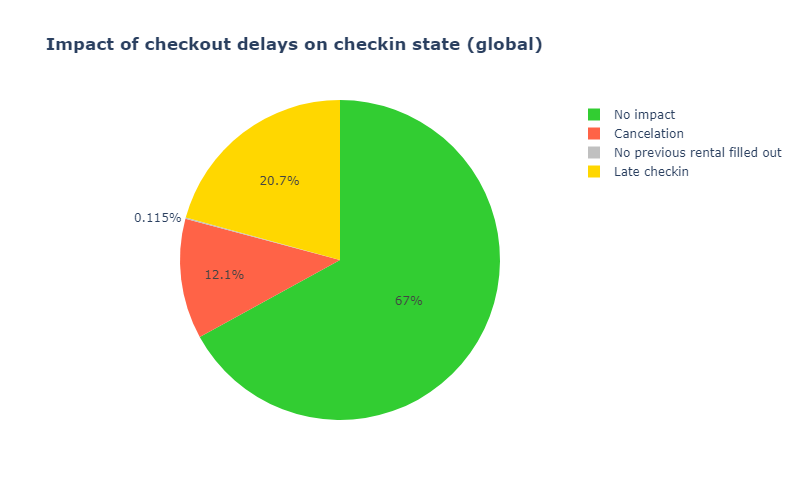

In [13]:
# Piechart of delays checkout impact on next checkin (no impact, late checkin, cancel)

data_copy = data.copy()
data_merged = data.merge(data_copy, how = "left", left_on = "previous_ended_rental_id", right_on = "rental_id", suffixes = ["_current", "_previous"])

data_with_previous = data_merged.dropna(subset = ["previous_ended_rental_id_current"])
data_with_previous.loc[:, "checkin_delay"] = data_with_previous["delays_previous"] - data_with_previous["time_delta_with_previous_rental_in_minutes_current"]

mask1 = (data_with_previous["state_current"] == "canceled")
mask2 = (data_with_previous["checkin_delay"] > 0) & (data_with_previous["state_current"] == "ended")
mask3 = (data_with_previous["checkin_delay"] < 0) & (data_with_previous["state_current"] == "ended")
data_with_previous.loc[:, "checkout_delay_impact"] = np.select([mask1, mask2, mask3], 
                                                               ["Cancelation", "Late checkin", "No impact"], 
                                                               default = "No previous rental filled out")
data_with_previous = data_with_previous[data_with_previous["precise_state_previous"] == "Late checkout"]

checkin_pie = px.pie(data_with_previous, 
                      names = "checkout_delay_impact", 
                      color = "checkout_delay_impact",
                      color_discrete_map = {
                            "No impact": "limegreen",
                            "Late checkin": "gold",
                            "Cancelation": "tomato",
                            "No previous rental filled out": "silver"},
                      category_orders = {"checkout_delay_impact": ["No impact", "Late ckeckin", "Cancelation", "No previous rental filled out"]},
                      title = "<b> Impact of checkout delays on checkin state (global) <b>",
                      height = 500, width = 800
                      )
checkin_pie.show()

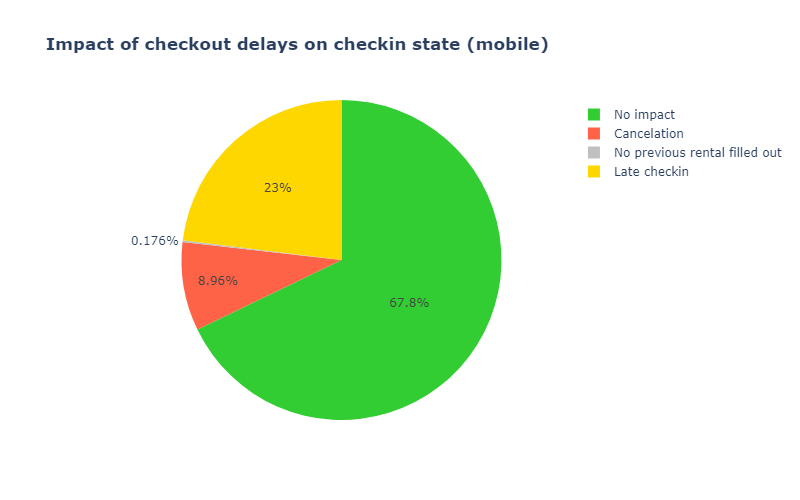

In [14]:
checkin_pie = px.pie(data_with_previous[data_with_previous["checkin_type_current"] == "mobile"], 
                      names = "checkout_delay_impact", 
                      color = "checkout_delay_impact",
                      color_discrete_map = {
                            "No impact": "limegreen",
                            "Late checkin": "gold",
                            "Cancelation": "tomato",
                            "No previous rental filled out": "silver"},
                      category_orders = {"checkout_delay_impact": ["No impact", "Late ckeckin", "Cancelation", "No previous rental filled out"]},
                      title = "<b> Impact of checkout delays on checkin state (mobile) <b>",
                      height = 500, width = 800
                      )
checkin_pie.show()

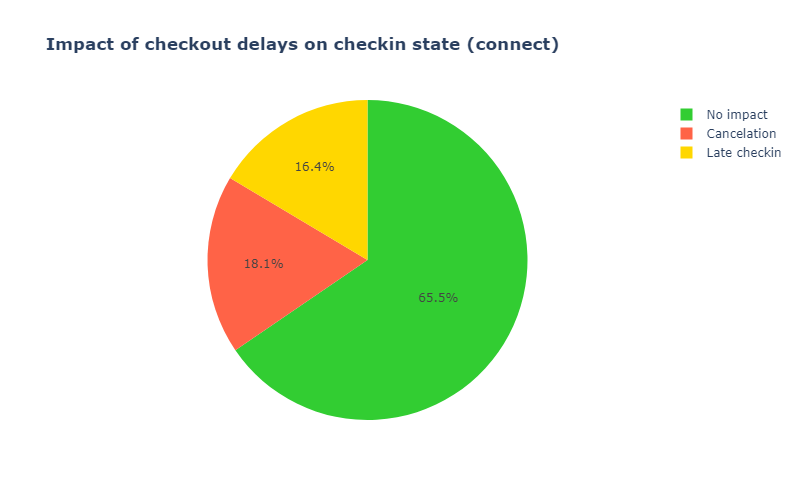

In [15]:
checkin_pie = px.pie(data_with_previous[data_with_previous["checkin_type_current"] == "connect"], 
                      names = "checkout_delay_impact", 
                      color = "checkout_delay_impact",
                      color_discrete_map = {
                            "No impact": "limegreen",
                            "Late checkin": "gold",
                            "Cancelation": "tomato",
                            "No previous rental filled out": "silver"},
                      category_orders = {"checkout_delay_impact": ["No impact", "Late ckeckin", "Cancelation", "No previous rental filled out"]},
                      title = "<b> Impact of checkout delays on checkin state (connect) <b>",
                      height = 500, width = 800
                      )
checkin_pie.show()

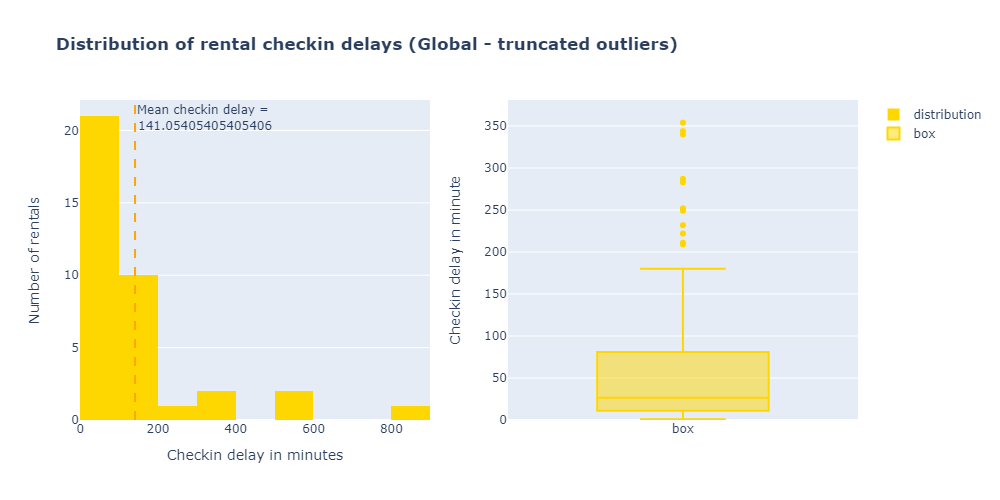

69.72% of rentals have a checkin delay of less then 1h due to a previous checkout delay.
The average checkin delay due to a previous checkout delay is 141 minutes.


In [16]:
# Distribution of late / cancelled checkin compared on the checkout delay (count vs time) with box (boîtes à moustaches)

data_with_previous["checkin"] = data_with_previous["checkin_delay"].apply(lambda x: 0 if x < 0 else x)

def detect_outliers(dataframe, feature_name):
    q1 = dataframe[feature_name].quantile(0.25)
    q3 = dataframe[feature_name].quantile(0.75)
    interquartile_range = q3 - q1
    upper_fence = math.ceil(q3 + 1.5 * interquartile_range)
    nb_rows = len(dataframe)
    mask = (dataframe[feature_name] <= upper_fence) | (dataframe[feature_name].isna())
    nb_outliers = nb_rows - len(dataframe[mask])
    percent_outliers = round(nb_outliers / nb_rows * 100)
    output = {
        'upper_fence': upper_fence,
        'percent_outliers': percent_outliers
    }
    return output

late_checkins_canceled_upper_fence = detect_outliers(data_with_previous[(data_with_previous["checkin"] > 0) & (data_with_previous["state_current"] == "canceled")], 'checkin')['upper_fence']

checkin_distribution = make_subplots(rows = 1, cols = 2)

checkin_distribution.add_trace(go.Histogram(x = data_with_previous[(data_with_previous["checkin"] > 0) & (data_with_previous["state_current"] == "canceled")]["checkin"], name = "distribution", marker_color = "gold"), row = 1, col = 1)
checkin_distribution.add_vline(x = data_with_previous[(data_with_previous["checkin"] > 0) & (data_with_previous["state_current"] == "canceled")]["checkin"].mean(), line_color = "orange", line_dash = "dash", annotation_text = f"Mean checkin delay = <br>{data_with_previous[(data_with_previous['checkin'] > 0) & (data_with_previous['state_current'] == 'canceled')]['checkin'].mean()}")
checkin_distribution.add_trace(go.Box(y = data_with_previous[(data_with_previous["checkin"] > 0)]["checkin"], name = "box", marker_color = "gold"), row = 1, col = 2)

checkin_distribution.update_xaxes(title_text = "Checkin delay in minutes", row = 1, col = 1)
checkin_distribution.update_yaxes(title_text = "Number of rentals", row = 1, col = 1)
checkin_distribution.update_yaxes(title_text = "Checkin delay in minute", row = 1, col = 2, range = [0, late_checkins_canceled_upper_fence+1])
checkin_distribution.update_layout(width = 1000, title_text = "<b> Distribution of rental checkin delays (Global - truncated outliers) <b>")

checkin_distribution.show()

print(f"{round(len(data_with_previous[(data_with_previous['checkin'] > 0) & (data_with_previous['checkin'] <= 60)]) / len(data_with_previous[data_with_previous['checkin'] > 0]) * 100, 2)}% of rentals have a checkin delay of less then 1h due to a previous checkout delay.")
print(f"The average checkin delay due to a previous checkout delay is {round(data_with_previous[(data_with_previous['checkin'] > 0) & (data_with_previous['state_current'] == 'canceled')]['checkin'].mean())} minutes.")

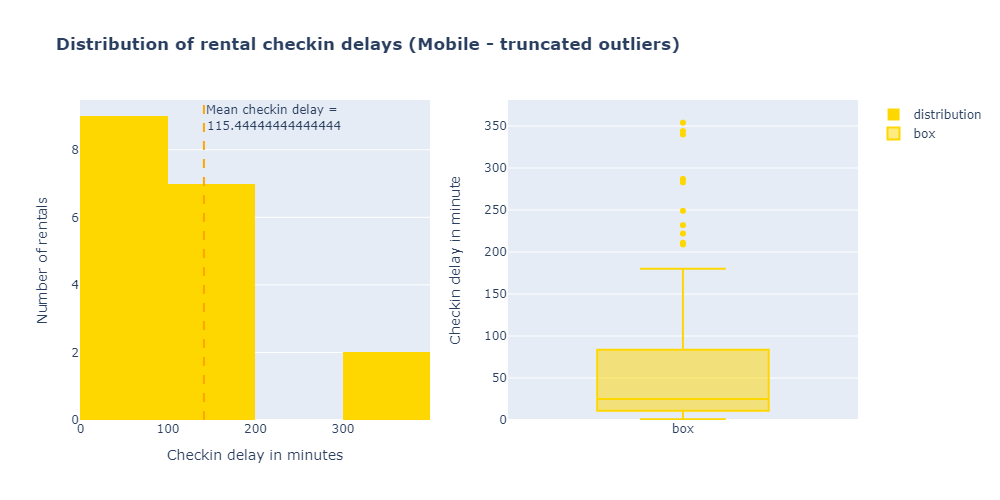

69.13% of rentals have a checkin delay of less then 1h due to a previous checkout delay.
The average checkin delay due to a previous checkout delay is 115 minutes.


In [17]:
checkin_distribution = make_subplots(rows = 1, cols = 2)

checkin_distribution.add_trace(go.Histogram(x = data_with_previous[(data_with_previous["checkin"] > 0) & (data_with_previous["state_current"] == "canceled") & (data_with_previous["checkin_type_current"] == "mobile")]["checkin"], name = "distribution", marker_color = "gold"), row = 1, col = 1)
checkin_distribution.add_vline(x = data_with_previous[(data_with_previous["checkin"] > 0) & (data_with_previous["state_current"] == "canceled")]["checkin"].mean(), line_color = "orange", line_dash = "dash", annotation_text = f"Mean checkin delay = <br>{data_with_previous[(data_with_previous['checkin'] > 0) & (data_with_previous['checkin_type_current'] == 'mobile') & (data_with_previous['state_current'] == 'canceled')]['checkin'].mean()}")
checkin_distribution.add_trace(go.Box(y = data_with_previous[(data_with_previous["checkin"] > 0) & (data_with_previous["checkin_type_current"] == "mobile")]["checkin"], name = "box", marker_color = "gold"), row = 1, col = 2)

checkin_distribution.update_xaxes(title_text = "Checkin delay in minutes", row = 1, col = 1)
checkin_distribution.update_yaxes(title_text = "Number of rentals", row = 1, col = 1)
checkin_distribution.update_yaxes(title_text = "Checkin delay in minute", row = 1, col = 2, range = [0, late_checkins_canceled_upper_fence+1])
checkin_distribution.update_layout(width = 1000, title_text = "<b> Distribution of rental checkin delays (Mobile - truncated outliers) <b>")

checkin_distribution.show()

print(f"{round(len(data_with_previous[(data_with_previous['checkin'] > 0) & (data_with_previous['checkin_type_current'] == 'mobile') & (data_with_previous['checkin'] <= 60)]) / len(data_with_previous[(data_with_previous['checkin'] > 0) & (data_with_previous['checkin_type_current'] == 'mobile')]) * 100, 2)}% of rentals have a checkin delay of less then 1h due to a previous checkout delay.")
print(f"The average checkin delay due to a previous checkout delay is {round(data_with_previous[(data_with_previous['checkin'] > 0) & (data_with_previous['checkin_type_current'] == 'mobile') & (data_with_previous['state_current'] == 'canceled')]['checkin'].mean())} minutes.")

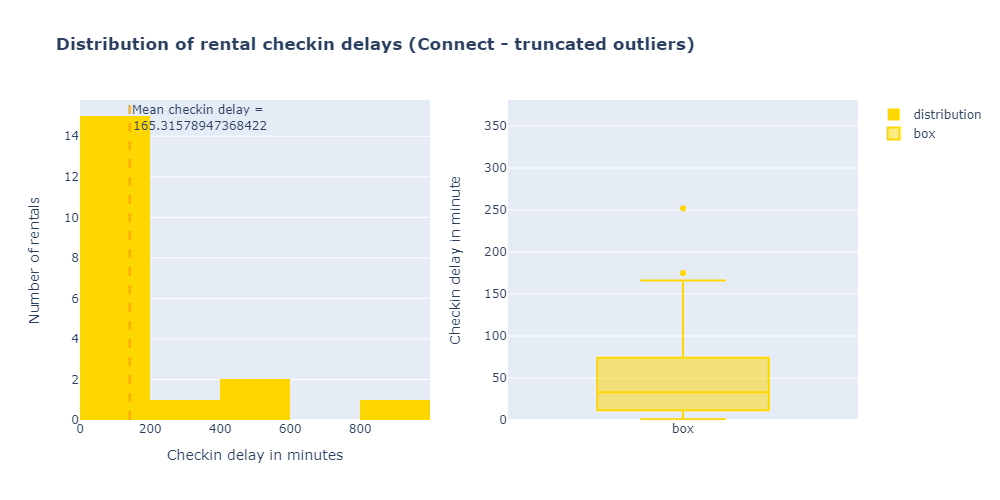

71.01% of rentals have a checkin delay of less then 1h due to a previous checkout delay.
The average checkin delay due to a previous checkout delay is 165 minutes.


In [18]:
checkin_distribution = make_subplots(rows = 1, cols = 2)

checkin_distribution.add_trace(go.Histogram(x = data_with_previous[(data_with_previous["checkin"] > 0) & (data_with_previous["state_current"] == "canceled") & (data_with_previous["checkin_type_current"] == "connect")]["checkin"], name = "distribution", marker_color = "gold"), row = 1, col = 1)
checkin_distribution.add_vline(x = data_with_previous[(data_with_previous["checkin"] > 0) & (data_with_previous["state_current"] == "canceled")]["checkin"].mean(), line_color = "orange", line_dash = "dash", annotation_text = f"Mean checkin delay = <br>{data_with_previous[(data_with_previous['checkin'] > 0) & (data_with_previous['checkin_type_current'] == 'connect') & (data_with_previous['state_current'] == 'canceled')]['checkin'].mean()}")
checkin_distribution.add_trace(go.Box(y = data_with_previous[(data_with_previous["checkin"] > 0) & (data_with_previous["checkin_type_current"] == "connect")]["checkin"], name = "box", marker_color = "gold"), row = 1, col = 2)

checkin_distribution.update_xaxes(title_text = "Checkin delay in minutes", row = 1, col = 1)
checkin_distribution.update_yaxes(title_text = "Number of rentals", row = 1, col = 1)
checkin_distribution.update_yaxes(title_text = "Checkin delay in minute", row = 1, col = 2, range = [0, late_checkins_canceled_upper_fence+1])
checkin_distribution.update_layout(width = 1000, title_text = "<b> Distribution of rental checkin delays (Connect - truncated outliers) <b>")

checkin_distribution.show()

print(f"{round(len(data_with_previous[(data_with_previous['checkin'] > 0) & (data_with_previous['checkin_type_current'] == 'connect') & (data_with_previous['checkin'] <= 60)]) / len(data_with_previous[(data_with_previous['checkin'] > 0) & (data_with_previous['checkin_type_current'] == 'connect')]) * 100, 2)}% of rentals have a checkin delay of less then 1h due to a previous checkout delay.")
print(f"The average checkin delay due to a previous checkout delay is {round(data_with_previous[(data_with_previous['checkin'] > 0) & (data_with_previous['checkin_type_current'] == 'connect') & (data_with_previous['state_current'] == 'canceled')]['checkin'].mean())} minutes.")

According to these figures, the following results are obtained :  
  
|         Rental checkin         |     Global     |      Mobile    |    Connect    |
| :----------------------------: | :------------: | :------------: | :-----------: |
| No impact                      | 67%            | 67.8%          | 65.5%         |
| Late checkin (mean in minutes) | 20.7% (141min) | 23% (115min)   | 16.4% (165min)|
| Cancelation                    | 12.1%          | 8.96%          | 18.1%         |
| No information                 | 0.115%         | 0.176%         | 0%            |
  
We can therefore see that most delays at checkout have no impact on the next reservation. However, when there is one, the delay to the next check-in is on average quite significant, although around 70% of check-in delays are less than 1 hour.